# QUESTION 1

In [ ]:
!pip install shutup

In [ ]:
import shutup; shutup.please()

In [ ]:
!pip install langdetect

In [ ]:
!pip install googletrans

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from langdetect import detect
from googletrans import Translator
from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
df = pd.read_csv("/content/only10k.csv")
df.head()

,Unnamed: 0,review,sentiment
0,33553,I really liked this Summerslam due to the look...,positive
1,9427,Not many television shows appeal to quite as m...,positive
2,199,The film quickly gets to a major chase scene w...,negative
3,12447,Jane Austen would definitely approve of this o...,positive
4,39489,Expectations were somewhat high for me when I ...,negative


In [ ]:
df = df.drop(df.columns[0], axis=1)

In [ ]:
df.shape, df['review'].nunique()

((10000, 2), 9978)

In [ ]:
df2 = df.copy()
df2 = df2.drop('sentiment', axis=1)

# EDA and Preprocessing

In [ ]:
df2.shape, df2['review'].nunique()

((10000, 1), 9978)

In [ ]:
df2.head()

,review
0,I really liked this Summerslam due to the look...
1,Not many television shows appeal to quite as m...
2,The film quickly gets to a major chase scene w...
3,Jane Austen would definitely approve of this o...
4,Expectations were somewhat high for me when I ...


In [ ]:
df2.columns

Index(['review'], dtype='object')

In [ ]:
df2.isna().sum()

review    0
dtype: int64

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


**Deleting Duplicates**

In [ ]:
dups_text = df2.pivot_table(columns=['review'], aggfunc='size')
df2.drop_duplicates(subset='review', keep='first', inplace=True)

In [ ]:
df.shape, df2.shape

((10000, 2), (9978, 1))

In [ ]:
df['review'].nunique()

9978

**Analysing Length**

In [ ]:
df2["length"] = df2["review"].apply(lambda x:len(x))
df2.head()

,review,length
0,I really liked this Summerslam due to the look...,1107
1,Not many television shows appeal to quite as m...,2054
2,The film quickly gets to a major chase scene w...,653
3,Jane Austen would definitely approve of this o...,632
4,Expectations were somewhat high for me when I ...,1900


In [ ]:
max_df2 = df2['length'].max()
print("Maximum length of review :",max_df2)

Maximum length of review : 7164


In [ ]:
min_df2 = df2['length'].min()
print("Minimum length of review :",min_df2)

Minimum length of review : 41


In [ ]:
for length in df2.sort_values(by="length", ascending=False)["review"][:3]:
    print(f"Review: \n{length}\n")

Review: 
Okay, so I'm not a big video game buff, but was the game House of the Dead really famous enough to make a movie from? Sure, they went as far as to actually put in quick video game clips throughout the movie, as though justifying any particular scene of violence, but there are dozens and dozens of games that look exactly the same, with the hand in the bottom on the screen, supposedly your own, holding whatever weapon and goo-ing all kinds of aliens or walking dead or snipers or whatever the case may be.<br /><br />It's an interesting premise in House of the Dead, with a lot of college kids (LOADED college kids, as it were, kids who are able to pay some fisherman something like $1,500 just for a ride after they miss their boat) trying to get out to this island for what is supposed to be the rave of the year. The first thing that comes to mind about House of the Dead after watching it is that it has become increasingly clear that modern horror movies have become nothing more than

In [ ]:
for length in df2.sort_values(by="length", ascending=True)["review"][:3]:
    print(f"Review: \n{length}\n")

Review: 
What a script, what a story, what a mess!

Review: 
This is a great movie. Too bad it is not available on home video.

Review: 
Brilliant and moving performances by Tom Courtenay and Peter Finch.



**Descriptive Statistics**

In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
length,9978.0,1314.161455,984.04894,41.0,700.0,975.0,1596.0,7164.0


In [ ]:
def cleanse(string):
    # Lower casing
    string = str(string).lower()

    # Getting rid of mentions
    # string = re.sub(r"@\S+", " ", string)

    # Removing HTML
    string = re.sub(r"&.*?;|<.*?>", " ", string)

    # URL removal
    string = re.sub(r"https?://\S+|www\.\S+", " ", string)

    # Handling abbreviations
    # string = convert_abbrev_in_text(string)

    # Non-word removals (special chars)
    string = re.sub(r"[^a-z]", " ", string)

    # Stop word removal
    string = " ".join(word for word in nltk.tokenize.word_tokenize(string) if word not in nltk.corpus.stopwords.words('english'))

    # Lemmatization
    lemma = nltk.stem.WordNetLemmatizer()
    string = " ".join(lemma.lemmatize(word) for word in nltk.tokenize.word_tokenize(string))

    # Single char removal
    string = re.sub(r"\b\w\b", "", string).strip()

    return string

In [ ]:
def detect_textlang(text):
    try:
        src_lang = detect(text)
        if src_lang =='en':
            return 'en'
        else:
        #return "NA"
            return src_lang
    except:
        return "NA"


In [ ]:
def translate_text(lang,text):
    translator= Translator()
    trans_text = translator.translate(text, src=lang).text
    return trans_text

In [ ]:
df2['cleaned']=df2['review'].apply(cleanse)

In [ ]:
df2['text_lang']=df2.cleaned.apply(detect_textlang)

In [ ]:
if df2[df2.text_lang == 'NA'].text_lang.count() != 0:
    df2.drop(df2[df2.text_lang == 'NA'].index, inplace=True)
    print('Deleted records with no character ')

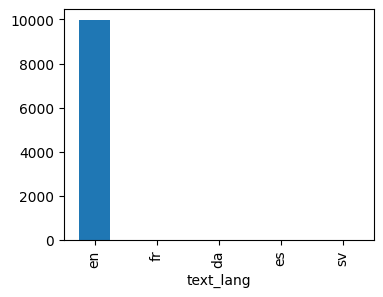

In [ ]:
plt.figure(figsize=(4,3))
df2.groupby(df2.text_lang).cleaned.count().sort_values(ascending=False).head(10).plot.bar()
plt.show()

In [ ]:
sia = SentimentIntensityAnalyzer()
df2['sia pol']=df2['cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])
df2['tb pol']=df2['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
df2['scores']=np.where(df2['tb pol']>0, 'pos', 'neg')

In [ ]:
df2.head()

,review,length,cleaned,text_lang,sia pol,tb pol,scores
0,I really liked this Summerslam due to the look...,1107,really liked summerslam due look arena curtain...,en,0.9020,-0.005417,neg
1,Not many television shows appeal to quite as m...,2054,many television show appeal quite many differe...,en,0.9799,0.193271,pos
2,The film quickly gets to a major chase scene w...,653,film quickly get major chase scene ever increa...,en,0.6712,0.213258,pos
3,Jane Austen would definitely approve of this o...,632,jane austen would definitely approve one gwyne...,en,0.9702,0.350714,pos
4,Expectations were somewhat high for me when I ...,1900,expectation somewhat high went see movie thoug...,en,-0.8892,-0.036810,neg


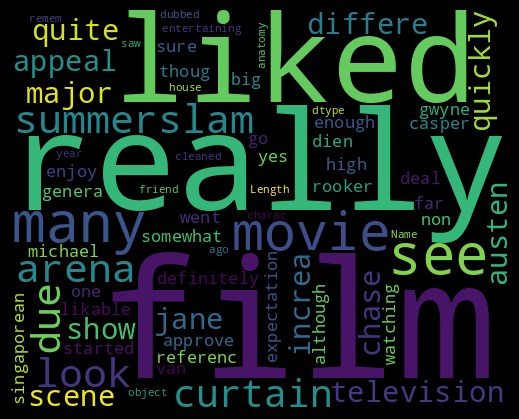

In [ ]:
review_pos = df2[df2['tb pol']=='pos']
text = df2['cleaned']
wordcloud = WordCloud(
    width = 500,
    height = 400,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (7, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

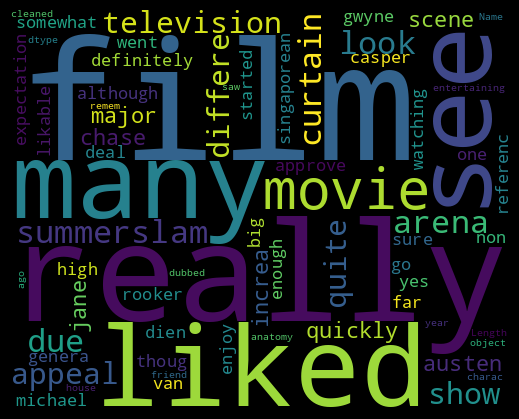

In [ ]:
review_pos = df2[df2['sia pol']=='pos']
text = df2['cleaned']
wordcloud = WordCloud(
    width = 500,
    height = 400,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (7, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<Axes: title={'center': 'Target Distribution Pie Chart'}, ylabel='scores'>

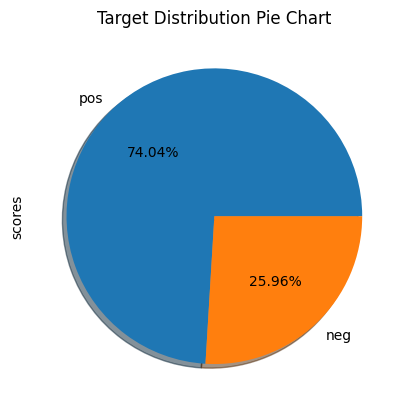

In [ ]:
plt.title("Target Distribution Pie Chart")
df2['scores'].value_counts().plot(kind="pie",autopct='%.2f%%',
    shadow=True)

# Modelling

In [ ]:
df2['scores'].value_counts()

pos    7388
neg    2590
Name: scores, dtype: int64

In [ ]:
# Split the data into training and testing sets, preserving the class distribution for balanced evaluation
X_train, X_test, y_train, y_test = train_test_split(df2['cleaned'], df2['scores'], train_size=0.8, stratify=df2['scores'])

In [ ]:
len(X_train),len(X_test)

(7982, 1996)

In [ ]:

# Create a LabelEncoder
label_encoder = LabelEncoder()
# Encode the sentiment labels to numeric values
y_train_encoded = label_encoder.fit_transform(y_train)

y_test_encoded = label_encoder.transform(y_test)

In [ ]:
model_names = []
f1_scores = []

In [ ]:
from sklearn.tree import DecisionTreeClassifier

models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('DT', DecisionTreeClassifier())
]


MultinomialNB F1 Score: 0.7279
LogisticRegression F1 Score: 0.8542
RandomForest F1 Score: 0.8121
XGBoost F1 Score: 0.8693
DT F1 Score: 0.7563


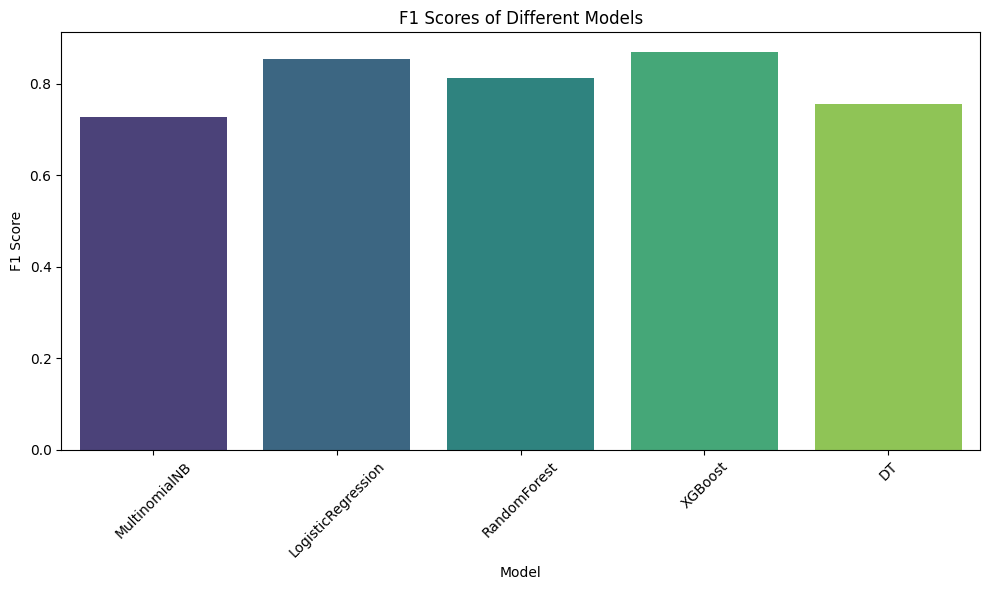

In [ ]:
for model_name, model in models:
  pipeline = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=5000)),
      ('model', model)
  ])
  pipeline.fit(X_train, y_train_encoded)  # Use the encoded labels here
  y_pred_encoded = pipeline.predict(X_test)  # Use the encoded labels for predictions
  f1_encoded = f1_score(y_test_encoded, y_pred_encoded, average='weighted')
  print(f"{model_name} F1 Score: {f1_encoded:.4f}")

  model_names.append(model_name)

  f1_scores.append(f1_encoded)

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
test = "I absolutely loved that film! The performances were outstanding, and the story was so engaging. It's one of the best movies I've seen in a long time."
review = cleanse(test)
predicted_sentiment = pipeline.predict([review])
print(f"Review: {review}")
print(f"Predicted Sentiment: {predicted_sentiment[0]}")

Review: absolutely loved film performance outstanding story engaging one best movie seen long time
Predicted Sentiment: 1


In [ ]:
test = "I found the acting in that movie to be terrible, and the plot was incredibly boring. It was a complete waste of time."
review = cleanse(test)
predicted_sentiment = pipeline.predict([review])
print(f"Review: {review}")
print(f"Predicted Sentiment: {predicted_sentiment[0]}")

Review: found acting movie terrible plot incredibly boring complete waste time
Predicted Sentiment: 0
